# Data Visualization for Startup Outcomes Paper
Kathleen Kennedy, 02-17-2022

In [19]:
import pandas as pd
import numpy as np
import math
import pathlib
import geopandas as gpd

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib_venn import venn3
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import seaborn as sns

from bokeh.models import ColumnDataSource, Label, LabelSet, Range1d
from bokeh.palettes import Viridis, RdBu
from bokeh.models import LinearColorMapper, ColumnDataSource, ColorBar
from bokeh.models.ranges import FactorRange
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.io import export_png, export_svg, export_svgs
from selenium import webdriver
from selenium.webdriver.firefox.options import Options

%matplotlib notebook

In [2]:
# Read in data
total_df = pd.read_csv('outputs/merged_venture_data.csv',low_memory=False)

tot_invested = total_df[~total_df['investor.firm.renamed'].isna()]
values = {'Sector':'uncategorized'}
tot_invested = tot_invested.fillna(value = values)

## Summary Numbers

In [3]:
print('Number of Companies: ' + str(len(tot_invested['Company'].unique())))
print('Number of Investors: ' + str(len(tot_invested['investor.firm.renamed'].unique()))) # plus 3 that aren't renamed
print('Number of Deals: ' + str(len(tot_invested)))

Number of Companies: 2910
Number of Investors: 3979
Number of Deals: 15108


In [4]:
(tot_invested.groupby(by=['investor.type.edited','investment.type']).size()
 .to_frame().rename(columns = {0:'investment.count'}))

investment.count
investor.type.edited             investment.type                  
corporation or corporate venture grant                          48
                                 growth equity                 974
                                 seed                          204
                                 series a                      567
                                 series b                      527
other investors                  grant                         251
                                 growth equity                3182
                                 seed                         2560
                                 series a                     3099
                                 series b                     2038
public or quasi public           grant                        1658

## Color palette for charts

In [5]:
list(reversed(RdBu[11]))

['#67001f',
 '#b2182b',
 '#d6604d',
 '#f4a582',
 '#fddbc7',
 '#f7f7f7',
 '#d1e5f0',
 '#92c5de',
 '#4393c3',
 '#2166ac',
 '#053061']

In [6]:
graph = figure(title = "Bokeh Palettes") 

graph.vbar(x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], # can go up to 11
           top = [3] * 11,
           bottom = [2] * 11,
           width = 1,
           color = RdBu[11])

show(graph)

## Figure 1: Investment over time and investor overlap

In [7]:
haz_df = pd.read_csv('outputs/hazard_data.csv')
haz_df.groupby(by = ['CVC_bin','Other_inv_bin','Public_grant_bin']).size().to_frame().rename(columns = {0:'count'})

count
CVC_bin Other_inv_bin Public_grant_bin       
0       0             1                   368
        1             0                  1323
                      1                   203
1       0             0                   133
                      1                    25
        1             0                   669
                      1                   189

<IPython.core.display.Javascript object>


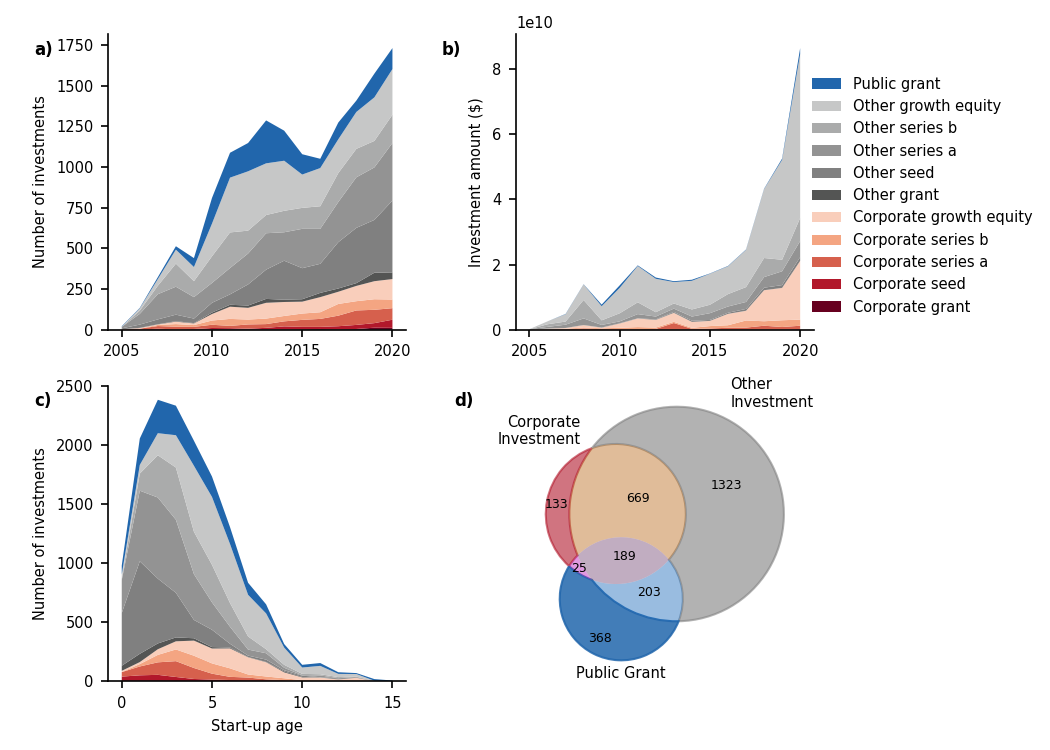

In [9]:
# Create figure grid and adjust default font parameters
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (7,5))

plt.rc('font', family='sans-serif') 
plt.rcParams['font.size'] = 7

# Calculate investment changes over time by investor and investment types
inv_time = total_df[['Company','investor.type.edited','investment.type',
                     'Year Founded','investment.year','investment.amount']]
inv_time = inv_time.dropna(subset = ['Year Founded','investment.year'])
inv_time['t_inv'] = inv_time['investment.year'] - inv_time['Year Founded']


type_t = (inv_time.groupby(by=['investment.year','investor.type.edited','investment.type'])
          .size().reset_index().rename(columns={0:'Count'}))
type_t = type_t.pivot(index = ['investor.type.edited','investment.type'],
            columns = 'investment.year',
            values = 'Count').fillna(0)
type_t = type_t.reindex(['grant','seed','series a','series b','growth equity'], level = 1)

# Make color palette, starts corporate, then other, ends public
myPal = ['#67001f','#b2182b','#d6604d','#f4a582','#F9CEBB',
         '#545554','#808080','#939393','#AAABAB','#C6C7C7', '#2166ac']

# Figure 1a. Number of investments over time
ax1.stackplot(type_t.columns, type_t.values, 
              labels = type_t.index, colors = myPal)
ax1.set_ylabel('Number of investments')
ax1.xaxis.set_major_locator(ticker.MaxNLocator(nbins = 4, integer=True))

# Figure 1b. Investment amounts over time
amt_t = (inv_time.groupby(by=['investment.year','investor.type.edited','investment.type'])
          .sum(numeric_only = True).reset_index())
amt_t = amt_t.pivot(index = ['investor.type.edited','investment.type'],
            columns = 'investment.year',
            values = 'investment.amount').fillna(0)

amt_t = amt_t.reindex(['grant','seed','series a','series b','growth equity'], level = 1)

ax2.stackplot(amt_t.columns, amt_t.values, 
              labels = amt_t.index, colors = myPal)
ax2.set_ylabel('Investment amount ($)')
ax2.xaxis.set_major_locator(ticker.MaxNLocator(nbins = 4, integer=True))

# Figure 1c. Number of investments by start-up age
s_t = (inv_time.groupby(by=['t_inv','investor.type.edited','investment.type'])
          .size().reset_index().rename(columns={0:'Count'}))
s_t = s_t.pivot(index = ['investor.type.edited','investment.type'],
            columns = 't_inv',
            values = 'Count').fillna(0)
s_t = s_t.reindex(['grant','seed','series a','series b','growth equity'], level = 1)

ax3.stackplot(s_t.columns, s_t.values, 
              labels = s_t.index, colors = myPal)
ax3.set_ylabel('Number of investments')
ax3.set_xlabel('Start-up age')
handles, labels = ax2.get_legend_handles_labels()
ax3.xaxis.set_major_locator(ticker.MaxNLocator(nbins = 4, integer=True))

# Figure 1d. Venn diagram of investor overlap
v = venn3(subsets = (133, 1323, 669, 368, 25, 203, 189), ax = ax4,
          set_labels = ('Corporate\nInvestment', 'Other\nInvestment','Public Grant'))

v.get_patch_by_id('100').set_color('#b2182b')
v.get_patch_by_id('100').set_alpha(0.6)
v.get_patch_by_id('010').set_color('#808080')
v.get_patch_by_id('010').set_alpha(0.6)
v.get_patch_by_id('001').set_color('#2166ac')
v.get_patch_by_id('001').set_alpha(0.85)

v.get_label_by_id('100').set_fontsize(6)
v.get_label_by_id('010').set_fontsize(6) 
v.get_label_by_id('001').set_fontsize(6) 
v.get_label_by_id('110').set_fontsize(6)
v.get_label_by_id('101').set_fontsize(6)
v.get_label_by_id('011').set_fontsize(6)
v.get_label_by_id('111').set_fontsize(6)

for text in v.set_labels:
    text.set_fontsize(7)
    
# Adjustments to overall figure
sns.despine()
handles, labels = ax1.get_legend_handles_labels()
labels = ['Corporate grant','Corporate seed',
          'Corporate series a', 'Corporate series b',
          'Corporate growth equity', 'Other grant',
          'Other seed', 'Other series a','Other series b',
          'Other growth equity', 'Public grant']
ax2.legend(reversed(handles), reversed(labels), 
           frameon = False, bbox_to_anchor=(0.95,.9), 
           loc="upper left")

ax1.annotate('a)', xy = (-0.25,0.93), xycoords = 'axes fraction', 
             size = 8, weight='bold')
ax2.annotate('b)', xy = (-0.25,0.93), xycoords = 'axes fraction', 
             size = 8, weight='bold')
ax3.annotate('c)', xy = (-0.25,0.93), xycoords = 'axes fraction', 
             size = 8, weight='bold')
ax4.annotate('d)', xy = (-0.25,0.93), xycoords = 'axes fraction', 
             size = 8, weight='bold')

plt.tight_layout()
plt.savefig('figs/Fig1_invs_time.jpg', bbox_inches='tight', dpi=300)

## Figure 2: Investment by Sector

<IPython.core.display.Javascript object>


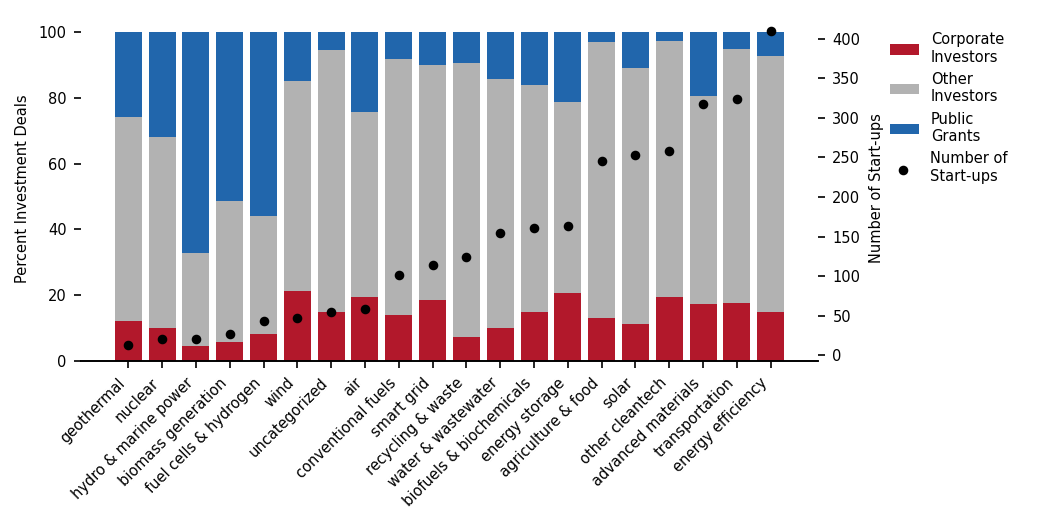

In [10]:
num_starts = tot_invested[['Company','Sector']].drop_duplicates()
num_starts = num_starts.groupby('Sector').size().to_frame().rename(columns={0:'Start-up Count'})
num_starts = num_starts.sort_values(by='Start-up Count', ascending = True)

sect_nums = tot_invested.fillna(value = {'investor.type.edited':'none'})
sect_nums = sect_nums.groupby(['Sector','investor.type.edited']).size().to_frame().rename(columns={0: "Deal Count"})
sect_nums = sect_nums.reset_index()
sect_tot = sect_nums.groupby('Sector').sum(numeric_only = True)

sect_nums['Percent Deals'] = sect_nums.apply(lambda row: 
                                             row['Deal Count'] / sect_tot.loc[row['Sector']] * 100,
                                             axis=1)

sect_corp_nums = sect_nums[sect_nums['investor.type.edited']=='corporation or corporate venture'].reset_index(drop=True)
sect_corp_nums = sect_corp_nums.merge(num_starts, on = 'Sector').sort_values('Start-up Count', ascending = True)
sect_oth_nums = sect_nums[sect_nums['investor.type.edited'] =='other investors'].reset_index(drop=True)
sect_oth_nums = sect_oth_nums.merge(num_starts, on = 'Sector').sort_values('Start-up Count', ascending = True)
sect_pub_nums = sect_nums[sect_nums['investor.type.edited']=='public or quasi public'].reset_index(drop=True)
sect_pub_nums = sect_pub_nums.merge(num_starts, on = 'Sector').sort_values('Start-up Count', ascending = True)


fig, ax = plt.subplots(figsize=(7,3.5))

plt.rc('font', family='sans-serif') 
plt.rcParams['font.size'] = 7

p1 = ax.bar(sect_corp_nums['Sector'], sect_corp_nums['Percent Deals'], 
            color='#b2182b', alpha = 1, label='Corporate\nInvestors')
p2 = ax.bar(sect_oth_nums['Sector'], sect_oth_nums['Percent Deals'], 
            bottom=sect_corp_nums['Percent Deals'], 
            color='#808080', alpha = 0.6,
            label='Other\nInvestors')
p3 = ax.bar(sect_pub_nums['Sector'], sect_pub_nums['Percent Deals'], 
            bottom=sect_corp_nums['Percent Deals']+sect_oth_nums['Percent Deals'], 
            color='#2166ac', alpha = 1, label='Public\nGrants')

ax.grid(False)
ax.set_ylabel('Percent Investment Deals')
ax.set_xlabel('')
plt.xticks(rotation=45, ha='right')
sns.despine(left=True)

ax2 = ax.twinx()
s = ax2.scatter(num_starts.index,num_starts['Start-up Count'], color='black', s = 13,
                label = 'Number of\nStart-ups', alpha=1)
ax2.grid(False)
ax2.set_ylabel('Number of Start-ups')
sns.despine(left=True)

ax.legend(bbox_to_anchor=(1.08, .99),frameon=False)
ax2.legend(bbox_to_anchor=(1.275, .645),frameon=False)
    
plt.tight_layout()
plt.savefig('Figs/Fig2_sector_invs.jpg', bbox_inches='tight', dpi = 300)

## Figure 3: Investment by Corporate Category

In [11]:
inv_sects = (tot_invested.dropna(subset=['investor.category'])
             .groupby(['investor.category','Sector']).size()
             .reset_index().rename(columns={0:'count'}))

inv_sect_tots = (inv_sects.groupby('investor.category')
                 .sum(numeric_only = True).reset_index().rename(columns={'count':'total'}))

inv_sects = inv_sects.merge(inv_sect_tots, on = 'investor.category')
inv_sects['percentage'] = inv_sects['count'] / inv_sects['total'] * 100

def format_categories(x):
    if x == 'digital and financial services ':
        return 'digital and\nfinancial services'
    if x == 'food, beverages & agriculture':
        return 'food, beverages\nand agriculture'
    if x == 'manufacturing, hardware, semiconductors, chemicals':
        return 'manufacturing, hardware,\nsemiconductors, and chemicals'
    return x
inv_sects.loc[:,'investor.category'] = (inv_sects['investor.category']
                                                   .apply(lambda x: format_categories(x)))

inv_sects.to_csv('outputs/corp_cats_to_sects.csv', encoding = 'utf-8', index = False)

In [12]:
# Set up browser driver
options = Options()
options.add_argument("--headless")
options.binary_location = r'C:\Program Files\Mozilla Firefox\firefox.exe'
driver = webdriver.Firefox(options=options)

# Set output to show in notebook
output_notebook()

source = ColumnDataSource(data=inv_sects)

# make colormap
colors = list(reversed(RdBu[10]))
exp_cmap = LinearColorMapper(palette=colors, 
                             low = 0, 
                             high = 65)

p = figure(x_range = FactorRange(), y_range = FactorRange(), plot_width=700, 
           plot_height=400,  toolbar_location=None, tools="hover")

p.scatter('Sector', 'investor.category', source = inv_sects, fill_alpha=0.8,  line_width=0, size='percentage', 
          fill_color={"field":"count", "transform":exp_cmap})

p.x_range.factors = sorted(inv_sects['Sector'].unique().tolist())
p.y_range.factors = sorted(inv_sects['investor.category'].unique().tolist(), reverse = True)

p.xaxis.axis_label = 'Start-up Sector'
p.yaxis.axis_label = 'Corporate Sector'
p.xaxis.axis_label_text_font_size = "7pt"
p.yaxis.axis_label_text_font_size = "7pt"
p.xaxis.major_label_text_font_size = "7pt"
p.yaxis.major_label_text_font_size = "7pt"
p.xaxis.axis_label_text_font = "sans-serif"
p.yaxis.axis_label_text_font = "sans-serif"
p.xaxis.major_label_text_font = "sans-serif"
p.yaxis.major_label_text_font = "sans-serif"
p.xaxis.axis_label_text_font_style = 'normal'
p.yaxis.axis_label_text_font_style = 'normal'
p.xaxis.major_label_orientation = math.pi/4 #"vertical"

bar = ColorBar(color_mapper=exp_cmap, location=(0,0), scale_alpha = 0.8,
              title = 'Percentage of Investments',
              title_text_align = 'left', title_text_font_size = "7pt",
              title_text_font_style = 'normal', title_text_font = 'sans-serif',
              major_label_text_font_size = "7pt")
p.add_layout(bar, "right")

p.border_fill_color = None

# Show image and save
show(p)
p.output_backend = "svg"
export_png(p, webdriver = driver, filename = 'Figs/Fig3_bubble_plot.png')
export_svg(p, webdriver = driver, filename = 'Figs/Fig3_bubble_plot.svg')

# The svg files in this don't work well in Adobe. To get an editable image,
# open with chrome and print to pdf, then edit pdf as needed.

Loading BokehJS ...

['Figs/Fig3_bubble_plot.svg']

## SI Figures

<IPython.core.display.Javascript object>


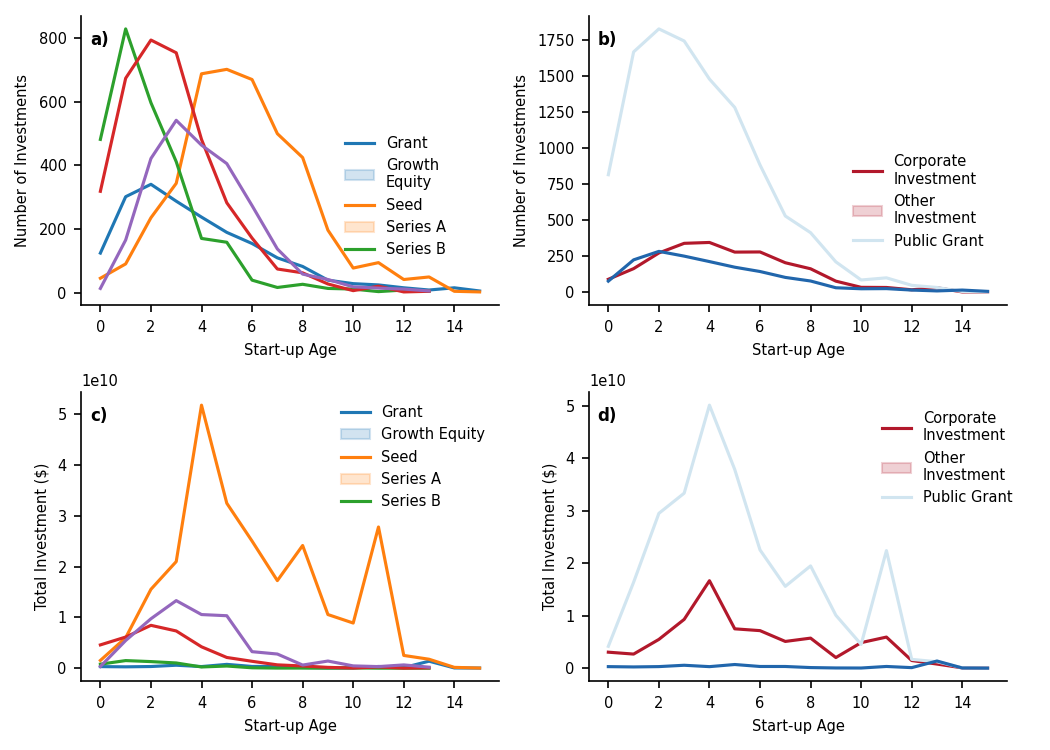

In [13]:
# Funding by startup age
inv_time = total_df[['Company','investor.type.edited','investment.type','Year Founded','investment.year','investment.amount']]
inv_time = inv_time.dropna(subset = ['Year Founded','investment.year'])
inv_time['t_inv'] = inv_time['investment.year'] - inv_time['Year Founded']

# Set defaults for figure
plt.rc('font', family='sans-serif') 
plt.rcParams['font.size'] = 7

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(7,5))

# Funding by startup age
inv_time = total_df[['Company','investor.type.edited','investment.type',
                     'Year Founded','investment.year','investment.amount']]
inv_time = inv_time.dropna(subset = ['Year Founded','investment.year'])
inv_time['t_inv'] = inv_time['investment.year'] - inv_time['Year Founded']

# investments by type by time since founding
type_t = (inv_time.groupby(by=['t_inv','investment.type']).size().reset_index()
          .rename(columns={0:'Count'}))

sns.lineplot(x = type_t.t_inv, y = type_t.Count, ax = ax1,
             hue = type_t['investment.type'])
sns.despine()
ax1.grid(False)
ax1.set_xlabel('Start-up Age')
ax1.set_ylabel('Number of Investments')
ax1.legend(frameon=False, labels=['Grant','Growth\nEquity','Seed',
                                  'Series A','Series B'],
          bbox_to_anchor = [.6,.12])

# investors by type by time since founding
inv_type_t = (inv_time.groupby(by=['t_inv','investor.type.edited']).size().reset_index()
              .rename(columns={0:'Count'}))

sns.lineplot(x = inv_type_t.t_inv, y = inv_type_t.Count, ax = ax2,
             hue = inv_type_t['investor.type.edited'], 
             palette=["#b2182b", "#d1e5f0", "#2166ac"])

sns.despine()
ax2.grid(False)
ax2.set_xlabel('Start-up Age')
ax2.set_ylabel('Number of Investments')
ax2.legend(frameon=False, bbox_to_anchor = [0.6,0.15],
           labels = ['Corporate\nInvestment','Other\nInvestment','Public Grant'])

# investments by type by time since founding
inv_type_t = (inv_time.groupby(by=['t_inv','investment.type'])
              .sum(numeric_only = True).reset_index())
sns.lineplot(x = inv_type_t.t_inv, y = inv_type_t['investment.amount'],
             ax = ax3, hue = type_t['investment.type'])
ax3.grid(False)
ax3.set_xlabel('Start-up Age')
ax3.set_ylabel('Total Investment ($)')
ax3.legend(frameon=False, labels=['Grant','Growth Equity','Seed',
                                  'Series A','Series B'])

# investors by type by time since founding
inv_type_t = (inv_time.groupby(by=['t_inv','investor.type.edited'])
              .sum(numeric_only = True).reset_index())
sns.lineplot(x = inv_type_t.t_inv, y = inv_type_t['investment.amount'],
             ax = ax4, hue = inv_type_t['investor.type.edited'],
             palette=["#b2182b", "#d1e5f0", "#2166ac"])

sns.despine()
ax4.grid(False)
ax4.set_xlabel('Start-up Age')
ax4.set_ylabel('Total Investment ($)')
ax4.legend(frameon=False, bbox_to_anchor = [0.67,0.98],
          labels = ['Corporate\nInvestment','Other\nInvestment','Public Grant'])

ax1.annotate('a)', xy = (0.02,0.9), xycoords = 'axes fraction', 
             size = 8, weight='bold')
ax2.annotate('b)', xy = (0.02,0.9), xycoords = 'axes fraction', 
             size = 8, weight='bold')
ax3.annotate('c)', xy = (0.02,0.9), xycoords = 'axes fraction', 
             size = 8, weight='bold')
ax4.annotate('d)', xy = (0.02,0.9), xycoords = 'axes fraction', 
             size = 8, weight='bold')

plt.tight_layout()
plt.savefig('Figs/FigS5_inv_time_USD.jpg', bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>


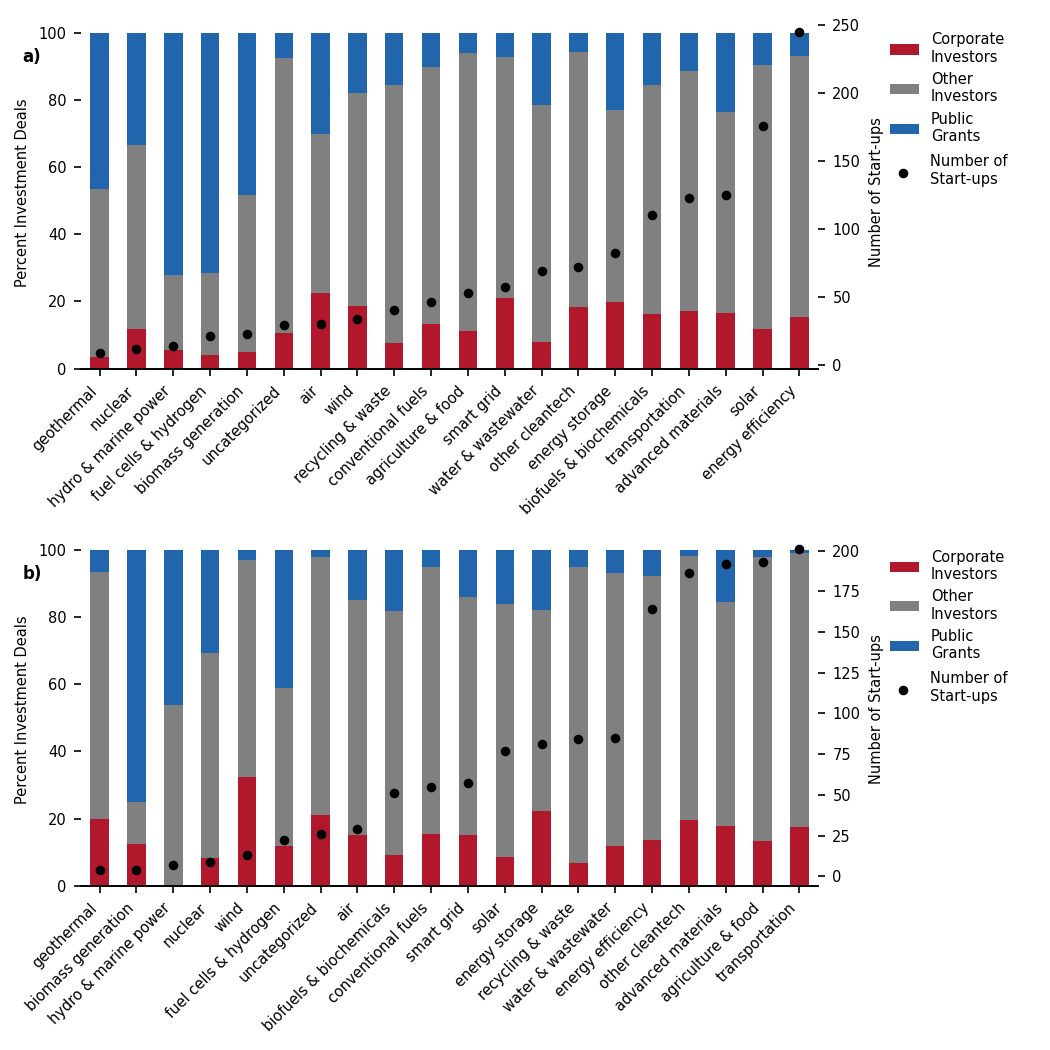

In [14]:
# Calculate data for Cleantech 1.0
tot_inv1 = tot_invested[tot_invested['Year Founded'] <= 2011]

num_starts1 = tot_inv1[['Company','Sector']].drop_duplicates()
num_starts1 = num_starts1.groupby('Sector').size().to_frame().rename(columns={0:'Start-up Count'})
num_starts1 = num_starts1.sort_values(by='Start-up Count', ascending = True)

sect_nums1 = tot_inv1.fillna(value = {'investor.type.edited':'none'})
sect_nums1 = sect_nums1.groupby(['Sector','investor.type.edited']).size().to_frame().rename(columns={0: "Deal Count"})
sect_nums1 = sect_nums1.reset_index()
sect_tot1 = sect_nums1.groupby('Sector').sum(numeric_only = True)

sect_nums1['Percent Deals'] = sect_nums1.apply(lambda row: 
                                             row['Deal Count'] / sect_tot1.loc[row['Sector']] * 100,
                                             axis=1)

sect_nums1 = (sect_nums1.pivot(index = 'Sector',
                              columns = 'investor.type.edited',
                              values = 'Percent Deals')
              .fillna(0).merge(num_starts1, left_index = True, right_on = 'Sector')
              .sort_values('Start-up Count', ascending = True)
              .drop('Start-up Count', axis = 1))

# Calculate data for Cleantech 2.0
tot_inv2 = tot_invested[tot_invested['Year Founded'] > 2011]

num_starts2 = tot_inv2[['Company','Sector']].drop_duplicates()
num_starts2 = num_starts2.groupby('Sector').size().to_frame().rename(columns={0:'Start-up Count'})
num_starts2 = num_starts2.sort_values(by='Start-up Count', ascending = True)

sect_nums2 = tot_inv2.fillna(value = {'investor.type.edited':'none'})
sect_nums2 = sect_nums2.groupby(['Sector','investor.type.edited']).size().to_frame().rename(columns={0: "Deal Count"})
sect_nums2 = sect_nums2.reset_index()
sect_tot2 = sect_nums2.groupby('Sector').sum(numeric_only = True)

sect_nums2['Percent Deals'] = sect_nums2.apply(lambda row: 
                                             row['Deal Count'] / sect_tot2.loc[row['Sector']] * 100,
                                             axis=1)
sect_nums2 = (sect_nums2.pivot(index = 'Sector',
                              columns = 'investor.type.edited',
                              values = 'Percent Deals')
              .fillna(0).merge(num_starts2, left_index = True, right_on = 'Sector')
              .sort_values('Start-up Count', ascending = True)
              .drop('Start-up Count', axis = 1)) 

# Make figure
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7,7))

plt.rc('font', family='sans-serif') 
plt.rcParams['font.size'] = 7

# a) Cleantech 1.0 
sect_nums1.plot(kind='bar', stacked='True', ax = ax1, 
                grid = False, color = ['#b2182b','#808080','#2166ac'], legend = False)
ax1.set_ylabel('Percent Investment Deals')
ax1.set_xlabel('')
ax1.set_xticklabels(sect_nums1.index, rotation=45, ha='right')
sns.despine(left=True)

ax3 = ax1.twinx()
s = ax3.scatter(num_starts1.index, num_starts1['Start-up Count'], color='black', s = 13,
                label = 'Number of\nStart-ups', alpha=1)
ax3.grid(False)
ax3.set_ylabel('Number of Start-ups')
sns.despine(left=True)

h, l = ax1.get_legend_handles_labels()
ax1.legend(h, ['Corporate\nInvestors','Other\nInvestors','Public\nGrants'],
          bbox_to_anchor=(1.08, .99),frameon=False)
ax3.legend(bbox_to_anchor=(1.275, .645),frameon=False)             

# b) Cleantech 2.0 
sect_nums2.plot(kind='bar', stacked='True',
              ax = ax2, color = ['#b2182b','#808080','#2166ac'],)

ax2.grid(False)
ax2.set_ylabel('Percent Investment Deals')
ax2.set_xlabel('')
ax2.set_xticklabels(sect_nums2.index, rotation=45, ha='right')
sns.despine(left=True)

ax4 = ax2.twinx()
s = ax4.scatter(num_starts2.index, num_starts2['Start-up Count'], color='black', s = 13,
                label = 'Number of\nStart-ups', alpha=1)
ax4.grid(False)
ax4.set_ylabel('Number of Start-ups')
sns.despine(left=True)

h, l = ax2.get_legend_handles_labels()
ax2.legend(h, ['Corporate\nInvestors','Other\nInvestors','Public\nGrants'],
          bbox_to_anchor=(1.08, .99),frameon=False)
ax4.legend(bbox_to_anchor=(1.275, .645),frameon=False)

ax1.annotate('a)', xy = (-0.08,0.87), xycoords = 'axes fraction', 
             size = 8, weight='bold')
ax2.annotate('b)', xy = (-0.08,0.87), xycoords = 'axes fraction', 
             size = 8, weight='bold')

plt.tight_layout()
plt.savefig('Figs/FigS1_sector_1vs2.jpg', bbox_inches='tight', dpi = 300)

### Map figure

shp files can be downloaded from:<br>
https://www2.census.gov/geo/tiger/TIGER2017/STATE/tl_2017_us_state.zip<br>
https://www2.census.gov/geo/tiger/TIGER2017/ZCTA5/tl_2017_us_zcta510.zip
<br>
<br>
adapted from code found at:<br> https://n8henrie.com/uploads/2017/11/plotting-us-census-data-with-python-and-geopandas.html <br>
<br>
Population census data from: <br>
https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html <br>

In [15]:
df = pd.read_csv('outputs/hazard_data.csv',encoding='utf-8')

def round_off(number):
    # Round to nearest 0.5 
    return math.ceil(number * 2) / 2

In [20]:
# read in mapping files for USA
states_filename = "tl_2017_us_state.zip"
states_file = pathlib.Path(states_filename)
states_gdf = gpd.read_file(f"zip://inputs/{states_file}")
population = pd.read_csv('inputs/state_census_data.csv')

<IPython.core.display.Javascript object>


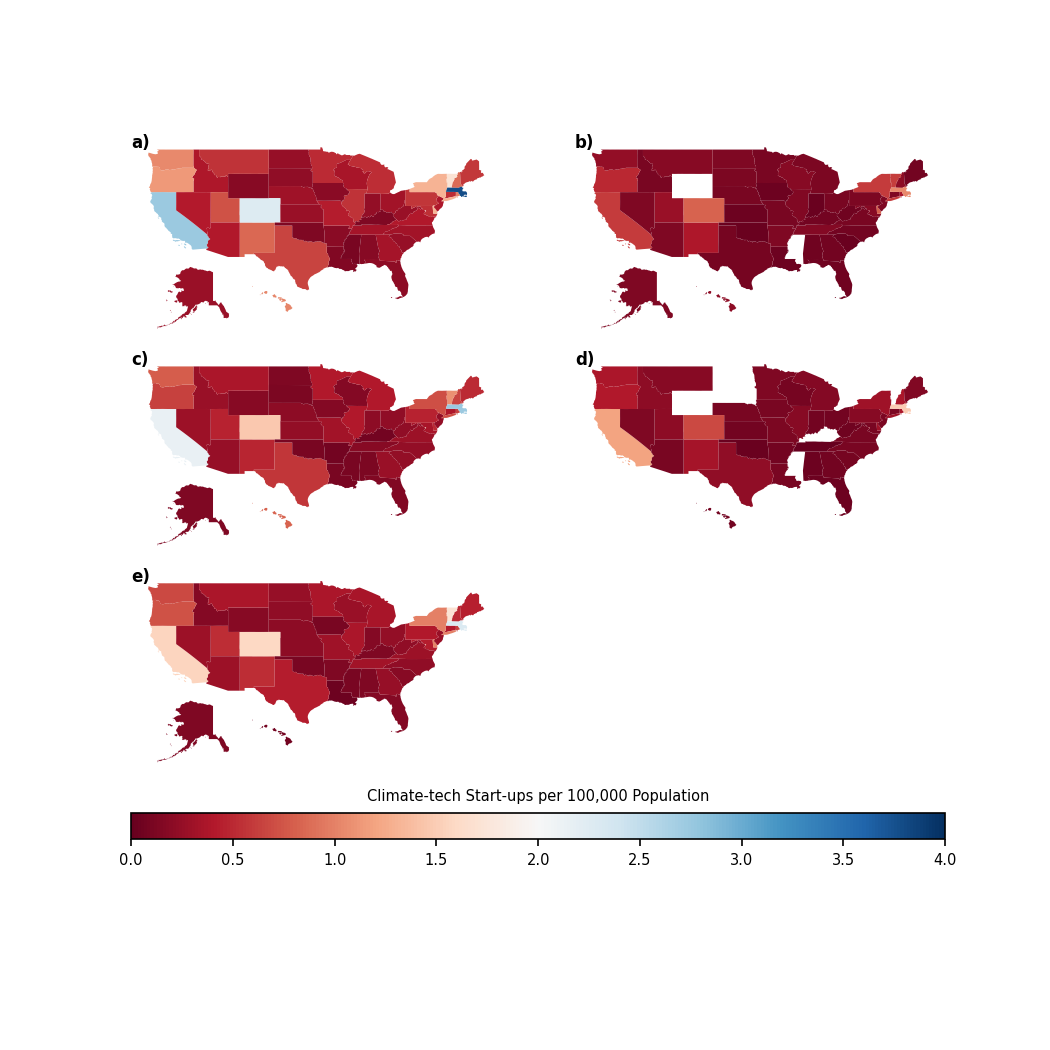

In [22]:
# Create figure with suplots
fig, axes = plt.subplots(3,2, figsize = (7,7))
(ax1, ax2, ax3, ax4, ax5, ax6) = axes.flat

#################
# Model 1
#################
# Get counts of startups in each state and normalize by population
state_count = df[['Company','State']].drop_duplicates()
state_count = state_count.groupby(by='State').size().reset_index().rename(columns={0:'counts'})
state_count.set_index('State', inplace = True)
state_count.rename(index={'Washington DC':'District of Columbia'}, inplace=True)
state_count.reset_index(drop = False,inplace=True)

population = population[['NAME','ESTIMATESBASE2020']]
state_count = state_count.merge(population, left_on = 'State', right_on='NAME',how='left')
state_count = state_count.drop(columns='NAME').rename(columns={'ESTIMATESBASE2020':'Population'})
state_count['Normalized'] = state_count['counts']/state_count['Population'] * 100000

# Model 1: Make map
not_mainland = ['Alaska', 'Hawaii', "Puerto Rico"]
mainland_usa = states_gdf.query('NAME not in @not_mainland')
mainland_usa = mainland_usa.merge(state_count, left_on='NAME',right_on='State', how='left')

min_val = 0
max_val = round_off(max(state_count['Normalized']))

my_cmap = cm.get_cmap('RdBu')
norm = mpl.colors.Normalize(min_val, max_val)

a = state_count.set_index('State').loc['Alaska','Normalized']
h = state_count.set_index('State').loc['Hawaii','Normalized']
color_a = my_cmap(norm(a))
color_h = my_cmap(norm(h))

im = mainland_usa.plot(column='Normalized', cmap=my_cmap, vmin = min_val, vmax = max_val,
                  ax = ax1)
ax1.set_axis_off()

alaska_inset1 = zoomed_inset_axes(ax1, zoom=0.5, bbox_to_anchor=(0.46, 0.31), 
                                 bbox_transform=ax1.transAxes)
alaska_inset1.set_xlim(-190,-120)
alaska_inset1.set_ylim(50,73)
alaska_inset1.set_axis_off()
gdf_alaska = states_gdf[states_gdf["NAME"] == "Alaska"].merge(state_count, left_on='NAME',right_on='State', how='left')
gdf_alaska.plot(ax=alaska_inset1, facecolor=color_a)

hawaii_inset1 = zoomed_inset_axes(ax1, zoom=1, bbox_to_anchor=(0.5, 0.2), 
                                 bbox_transform=ax1.transAxes)
hawaii_inset1.set_xlim(-162,-152)
hawaii_inset1.set_ylim(18,24)
hawaii_inset1.set_axis_off()
gdf_hawaii = states_gdf[states_gdf["NAME"] == "Hawaii"].merge(state_count, left_on='NAME',right_on='State', how='left')
gdf_hawaii.plot(ax=hawaii_inset1, facecolor=color_h)

##############
# Model 2
##############
mod2_df = df[df['Public_grant_bin'] == 1]

# Get counts of startups in each state (maybe should normalize by population or GDP or something...?)
state_count = mod2_df[['Company','State']].drop_duplicates()
state_count = state_count.groupby(by='State').size().reset_index().rename(columns={0:'counts'})
state_count.set_index('State', inplace = True)
state_count.rename(index={'Washington DC':'District of Columbia'}, inplace=True)
state_count.reset_index(drop = False,inplace=True)

state_count = state_count.merge(population, left_on = 'State', right_on='NAME',how='left')
state_count = state_count.drop(columns='NAME').rename(columns={'ESTIMATESBASE2020':'Population'})
state_count['Normalized'] = state_count['counts']/state_count['Population'] * 100000

# Make map
not_mainland = ['Alaska', 'Hawaii', "Puerto Rico"]
mainland_usa = states_gdf.query('NAME not in @not_mainland')
mainland_usa = mainland_usa.merge(state_count, left_on='NAME',right_on='State', how='left')

a = state_count.set_index('State').loc['Alaska','Normalized']
h = state_count.set_index('State').loc['Hawaii','Normalized']
color_a = my_cmap(norm(a))
color_h = my_cmap(norm(h))

mainland_usa.plot(column='Normalized', cmap=my_cmap, 
                  vmin = min_val, vmax = max_val, ax = ax2)
ax2.set_axis_off()

alaska_inset2 = zoomed_inset_axes(ax2, zoom=0.5, bbox_to_anchor=(0.46, 0.31), 
                                  bbox_transform=ax2.transAxes)
alaska_inset2.set_xlim(-190,-120)
alaska_inset2.set_ylim(50,73)
alaska_inset2.set_axis_off()
gdf_alaska = states_gdf[states_gdf["NAME"] == "Alaska"].merge(state_count, left_on='NAME',right_on='State', how='left')
gdf_alaska.plot(ax=alaska_inset2,facecolor=color_a)

hawaii_inset2 = zoomed_inset_axes(ax2, zoom=1, bbox_to_anchor=(0.5, 0.2), 
                                  bbox_transform=ax2.transAxes)
hawaii_inset2.set_xlim(-162,-152)
hawaii_inset2.set_ylim(18,24)
hawaii_inset2.set_axis_off()
gdf_hawaii = states_gdf[states_gdf["NAME"] == "Hawaii"].merge(state_count, left_on='NAME',right_on='State', how='left')
gdf_hawaii.plot(ax=hawaii_inset2,facecolor=color_h)

#############
# Model 3
#############
mod3_df = df[df['Public_grant_bin'] == 0]

# Get counts of startups in each state (maybe should normalize by population or GDP or something...?)
state_count = mod3_df[['Company','State']].drop_duplicates()
state_count = state_count.groupby(by='State').size().reset_index().rename(columns={0:'counts'})
state_count.set_index('State', inplace = True)
state_count.rename(index={'Washington DC':'District of Columbia'}, inplace=True)
state_count.reset_index(drop = False,inplace=True)

state_count = state_count.merge(population, left_on = 'State', right_on='NAME',how='left')
state_count = state_count.drop(columns='NAME').rename(columns={'ESTIMATESBASE2020':'Population'})
state_count['Normalized'] = state_count['counts']/state_count['Population'] * 100000
#state_count

# Make map
not_mainland = ['Alaska', 'Hawaii', "Puerto Rico"]
mainland_usa = states_gdf.query('NAME not in @not_mainland')
mainland_usa = mainland_usa.merge(state_count, left_on='NAME',right_on='State', how='left')

a = state_count.set_index('State').loc['Alaska','Normalized']
h = state_count.set_index('State').loc['Hawaii','Normalized']
color_a = my_cmap(norm(a))
color_h = my_cmap(norm(h))

mainland_usa.plot(column='Normalized', cmap=my_cmap, ax = ax3,
                  vmin = min_val, vmax = max_val)
ax3.set_axis_off()

alaska_inset3 = zoomed_inset_axes(ax3, zoom=0.5, bbox_to_anchor=(0.46, 0.31), 
                                  bbox_transform=ax3.transAxes)
alaska_inset3.set_xlim(-190,-120)
alaska_inset3.set_ylim(50,73)
alaska_inset3.set_axis_off()
gdf_alaska = states_gdf[states_gdf["NAME"] == "Alaska"].merge(state_count, left_on='NAME',right_on='State', how='left')
gdf_alaska.plot(ax=alaska_inset3,facecolor=color_a)

hawaii_inset3 = zoomed_inset_axes(ax3, zoom=1, bbox_to_anchor=(0.5, 0.2), 
                                  bbox_transform=ax3.transAxes)
hawaii_inset3.set_xlim(-162,-152)
hawaii_inset3.set_ylim(18,24)
hawaii_inset3.set_axis_off()
gdf_hawaii = states_gdf[states_gdf["NAME"] == "Hawaii"].merge(state_count, left_on='NAME',right_on='State', how='left')
gdf_hawaii.plot(ax=hawaii_inset3,facecolor=color_h)

#############
# Model 4
#############
mod4_df = df[df['CVC_bin'] == 1]

# Get counts of startups in each state (maybe should normalize by population or GDP or something...?)
state_count = mod4_df[['Company','State']].drop_duplicates()
state_count = state_count.groupby(by='State').size().reset_index().rename(columns={0:'counts'})
state_count.set_index('State', inplace = True)
state_count.rename(index={'Washington DC':'District of Columbia'}, inplace=True)
state_count.reset_index(drop = False,inplace=True)

state_count = state_count.merge(population, left_on = 'State', right_on='NAME',how='left')
state_count = state_count.drop(columns='NAME').rename(columns={'ESTIMATESBASE2020':'Population'})
state_count['Normalized'] = state_count['counts']/state_count['Population'] * 100000

# Make map
mainland_usa = states_gdf.query('NAME not in @not_mainland')
mainland_usa = mainland_usa.merge(state_count, left_on='NAME',right_on='State', how='left')

h = state_count.set_index('State').loc['Hawaii','Normalized']
color_h = my_cmap(norm(h))

mainland_usa.plot(column='Normalized', cmap=my_cmap, 
                  vmin = min_val, vmax = max_val, ax = ax4)
ax4.set_axis_off()

hawaii_inset4 = zoomed_inset_axes(ax4, zoom=1, bbox_to_anchor=(0.5, 0.2), 
                                  bbox_transform=ax4.transAxes)
hawaii_inset4.set_xlim(-162,-152)
hawaii_inset4.set_ylim(18,24)
hawaii_inset4.set_axis_off()
gdf_hawaii = states_gdf[states_gdf["NAME"] == "Hawaii"].merge(state_count, left_on='NAME',right_on='State', how='left')
gdf_hawaii.plot(ax=hawaii_inset4,facecolor=color_h)

#############
# Model 5
#############
mod5_df = df[df['CVC_bin'] == 0]

# Get counts of startups in each state (maybe should normalize by population or GDP or something...?)
state_count = mod5_df[['Company','State']].drop_duplicates()
state_count = state_count.groupby(by='State').size().reset_index().rename(columns={0:'counts'})
state_count.set_index('State', inplace = True)
state_count.rename(index={'Washington DC':'District of Columbia'}, inplace=True)
state_count.reset_index(drop = False,inplace=True)

state_count = state_count.merge(population, left_on = 'State', right_on='NAME',how='left')
state_count = state_count.drop(columns='NAME').rename(columns={'ESTIMATESBASE2020':'Population'})
state_count['Normalized'] = state_count['counts']/state_count['Population'] * 100000
#state_count

# Make map
mainland_usa = states_gdf.query('NAME not in @not_mainland')
mainland_usa = mainland_usa.merge(state_count, left_on='NAME',right_on='State', how='left')

mainland_usa.plot(column='Normalized', cmap=my_cmap, ax = ax5, 
                  vmin = min_val, vmax = max_val)
ax5.set_axis_off()

alaska_inset5 = zoomed_inset_axes(ax5, zoom=0.5, bbox_to_anchor=(0.46, 0.31), 
                                  bbox_transform=ax5.transAxes)
alaska_inset5.set_xlim(-190,-120)
alaska_inset5.set_ylim(50,73)
alaska_inset5.set_axis_off()
gdf_alaska = states_gdf[states_gdf["NAME"] == "Alaska"].merge(state_count, left_on='NAME',right_on='State', how='left')
gdf_alaska.plot(ax=alaska_inset5,facecolor=color_a)

hawaii_inset5 = zoomed_inset_axes(ax5, zoom=1, bbox_to_anchor=(0.5, 0.2), 
                                  bbox_transform=ax5.transAxes)
hawaii_inset5.set_xlim(-162,-152)
hawaii_inset5.set_ylim(18,24)
hawaii_inset5.set_axis_off()
gdf_hawaii = states_gdf[states_gdf["NAME"] == "Hawaii"].merge(state_count, left_on='NAME',right_on='State', how='left')
gdf_hawaii.plot(ax=hawaii_inset5,facecolor=color_h)

ax6.set_axis_off()

sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=mpl.colors.Normalize(vmin=min_val, vmax=max_val))
cb = plt.colorbar(sm, location = 'bottom', ax = axes, pad = 0.09, aspect = 32)
cb.ax.set_title("Climate-tech Start-ups per 100,000 Population", fontsize = 7)
cb.ax.tick_params(labelsize=7)

ax1.annotate('a)', xy = (0,0.95), xycoords = 'axes fraction', 
             size = 8, weight='bold')
ax2.annotate('b)', xy = (0,0.95), xycoords = 'axes fraction', 
             size = 8, weight='bold')
ax3.annotate('c)', xy = (0,0.95), xycoords = 'axes fraction', 
             size = 8, weight='bold')
ax4.annotate('d)', xy = (0,0.95), xycoords = 'axes fraction', 
             size = 8, weight='bold')
ax5.annotate('e)', xy = (0,0.95), xycoords = 'axes fraction', 
             size = 8, weight='bold')

#plt.tight_layout()
plt.savefig('Figs/FigS4_maps.jpg', bbox_inches='tight', dpi = 300)